## Necessary conditions for Jobsequencing
### Install pyQUBO from Recruit Communications Co. Ltd.
    pip install pyqubo
### Install openJij from Jij Inc.  (startup from Tohoku University)
    pip install openjij

# Solve Jobsequencing

### import pyQUBO, openJij, numpy, and matplotlib

In [1]:
from pyqubo  import Array,Constraint, Placeholder
import openjij as jij
import numpy as np
import matplotlib.pyplot as plt

Array, Constrains and Placeholders are convenient classes from pyQUBO

### Prepare binary variables

In [2]:
N = 10
M = 3
ymax = 10
vartype = "BINARY"
q = Array.create("q",shape=[M,N],vartype=vartype)
y = Array.create("y",shape=ymax,vartype=vartype)

"q" is name of variables  
shape specifies the shape of variables as vector, matrix, or...  
vartype selects -1 or 1 by "SPIN" and 0 or 1by "BINARY"

In [3]:
print(q)

Array([[Binary(q[0][0]), Binary(q[0][1]), Binary(q[0][2]), Binary(q[0][3]), Binary(q[0][4]), Binary(q[0][5]), Binary(q[0][6]), Binary(q[0][7]), Binary(q[0][8]), Binary(q[0][9])],
       [Binary(q[1][0]), Binary(q[1][1]), Binary(q[1][2]), Binary(q[1][3]), Binary(q[1][4]), Binary(q[1][5]), Binary(q[1][6]), Binary(q[1][7]), Binary(q[1][8]), Binary(q[1][9])],
       [Binary(q[2][0]), Binary(q[2][1]), Binary(q[2][2]), Binary(q[2][3]), Binary(q[2][4]), Binary(q[2][5]), Binary(q[2][6]), Binary(q[2][7]), Binary(q[2][8]), Binary(q[2][9])]])


In [4]:
print(y)

Array([Binary(y[0]), Binary(y[1]), Binary(y[2]), Binary(y[3]), Binary(y[4]), Binary(y[5]), Binary(y[6]), Binary(y[7]), Binary(y[8]), Binary(y[9])])


### Prepare values and weights

In [5]:
Lmax = 5
L = np.random.randint(1,Lmax,N)
n = np.linspace(1,ymax,ymax)

### Define cost function

In [6]:
E1 = Constraint(np.sum((np.sum(q,axis=0)-1)**2,axis=0),"select")

In [7]:
E2 = 0
for k in range(M):
    temp = 0
    for i in range(N):
        temp += L[i]*(q[k][i]-q[0][i])
    temp += np.dot(n,y)
    E2 += temp**2
E2 = Constraint(E2,"y")

In [8]:
E3 = 0
for i in range(N):
    E3 += L[i]*q[0][i]

In [9]:
Lam1 = Placeholder('Lam1')
Lam2 = Placeholder('Lam2')
E_cost = Lam1*E1+Lam2*E2+E3

### Compile the cost function

In [10]:
model = E_cost.compile()

### Get qubo matrix

In [11]:
feed_dict = {'Lam1': 10.0,'Lam2': 10.0}
Q, offset = model.to_qubo(feed_dict=feed_dict)

### Prepare simulation of quantum annealing

In [12]:
#simulated quantum annealing
sampler = jij.SQASampler(beta=10.0, gamma=1.0, trotter=4, num_sweeps=100)
#simulated annealing
#sampler = jij.SASampler(num_sweeps=1000)

This is done by quantum Monte-Carlo simulation  
gamma = strength of quantum fluctuation  
trotter = Trotter number  
num_sweeps = length of MCS

### Let's simulate quantum annealing

In [13]:
response = sampler.sample_qubo(Q)

### Show results

In [14]:
print(response)

  q[0][0] q[0][1] q[0][2] q[0][3] q[0][4] q[0][5] ... y[9] energy num_oc.
0       1       0       1       0       0       0 ...    0   65.0       1
['BINARY', 1 rows, 1 samples, 40 variables]


### minimum sample

In [15]:
response.record["sample"]

array([[1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1,
        1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int8)

### decode solution through pyQUBO

In [19]:
dsol, broken, energy = model.decode_solution(response.record["sample"][0], feed_dict = feed_dict, vartype=vartype)

In [21]:
dsol["q"]

{0: {0: 1, 1: 0, 2: 1, 3: 0, 4: 0, 5: 0, 6: 1, 7: 1, 8: 0, 9: 1},
 1: {0: 0, 1: 1, 2: 0, 3: 0, 4: 1, 5: 0, 6: 1, 7: 1, 8: 0, 9: 0},
 2: {0: 0, 1: 1, 2: 1, 3: 0, 4: 1, 5: 1, 6: 1, 7: 0, 8: 0, 9: 0}}

In [22]:
dsol["y"]

{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}

### Show results

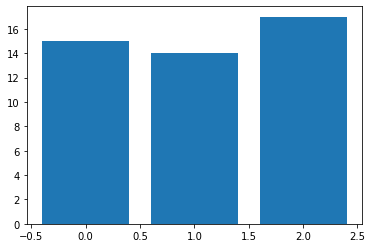

In [23]:
time = np.zeros(M)
for k in range(M):
    for keys in dsol["q"][k]:
        if dsol["q"][k][keys] == 1:
            time[k] += L[keys]
plt.bar(range(M),time)
plt.show()